In [ ]:
pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [ ]:
# Read in the training data (images and their corresponding masks)
# Before running this code, make sure the folder containing the images and masks are saved as a zip file
# Run the code and select the zip file to upload the data
from google.colab import files # Import he Path object from the google.colab module
import os
import shutil

# Upload the zip file
uploaded = files.upload()

# Extract the uploaded zip file
for filename in uploaded.keys():
    # Create a directory with the same name as the zip file (without the .zip extension)
    folder_name = os.path.splitext(filename)[0]
    os.makedirs(folder_name, exist_ok=True)
    # Extract the contents of the zip file into the newly created directory
    shutil.unpack_archive(filename, folder_name)
    print(f"Uploaded folder '{folder_name}'")

Saving data_training.zip to data_training.zip
Uploaded folder 'data_training'


In [ ]:
# Load images from the sub-folder test that have not been used during training

X = sorted(glob('data_training/data/test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))


Normalizing image channels independently.


In [ ]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

In [ ]:
# Run the code then, select the models.zip file (download in the model_training notebook) from your local file system to upload it to this Colab environment
from google.colab import files
uploaded = files.upload()


Saving models.zip to models.zip


In [ ]:
# This will extract the contents of models.zip into a directory named models/ in this Colab environment
import zipfile
with zipfile.ZipFile('models.zip', 'r') as zip_ref:
    zip_ref.extractall('models/')


In [ ]:
# Check the file structure
!find models -type d | sed -e "s/[^-][^\/]*\// |/g" -e "s/|\([^ ]\)/|-\1/"

models
 |-models
 | |-stardist_model
 | | |-logs
 | | | |-validation
 | | | |-images
 | | | |-train


In [ ]:
# Now, load the trained model along with its associated files using the StarDist2D class
model = StarDist2D(None, name='stardist_model', basedir='models/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.515234, nms_thresh=0.3.


In [ ]:
# Normalize the images before the prediction
img = normalize(X[3], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

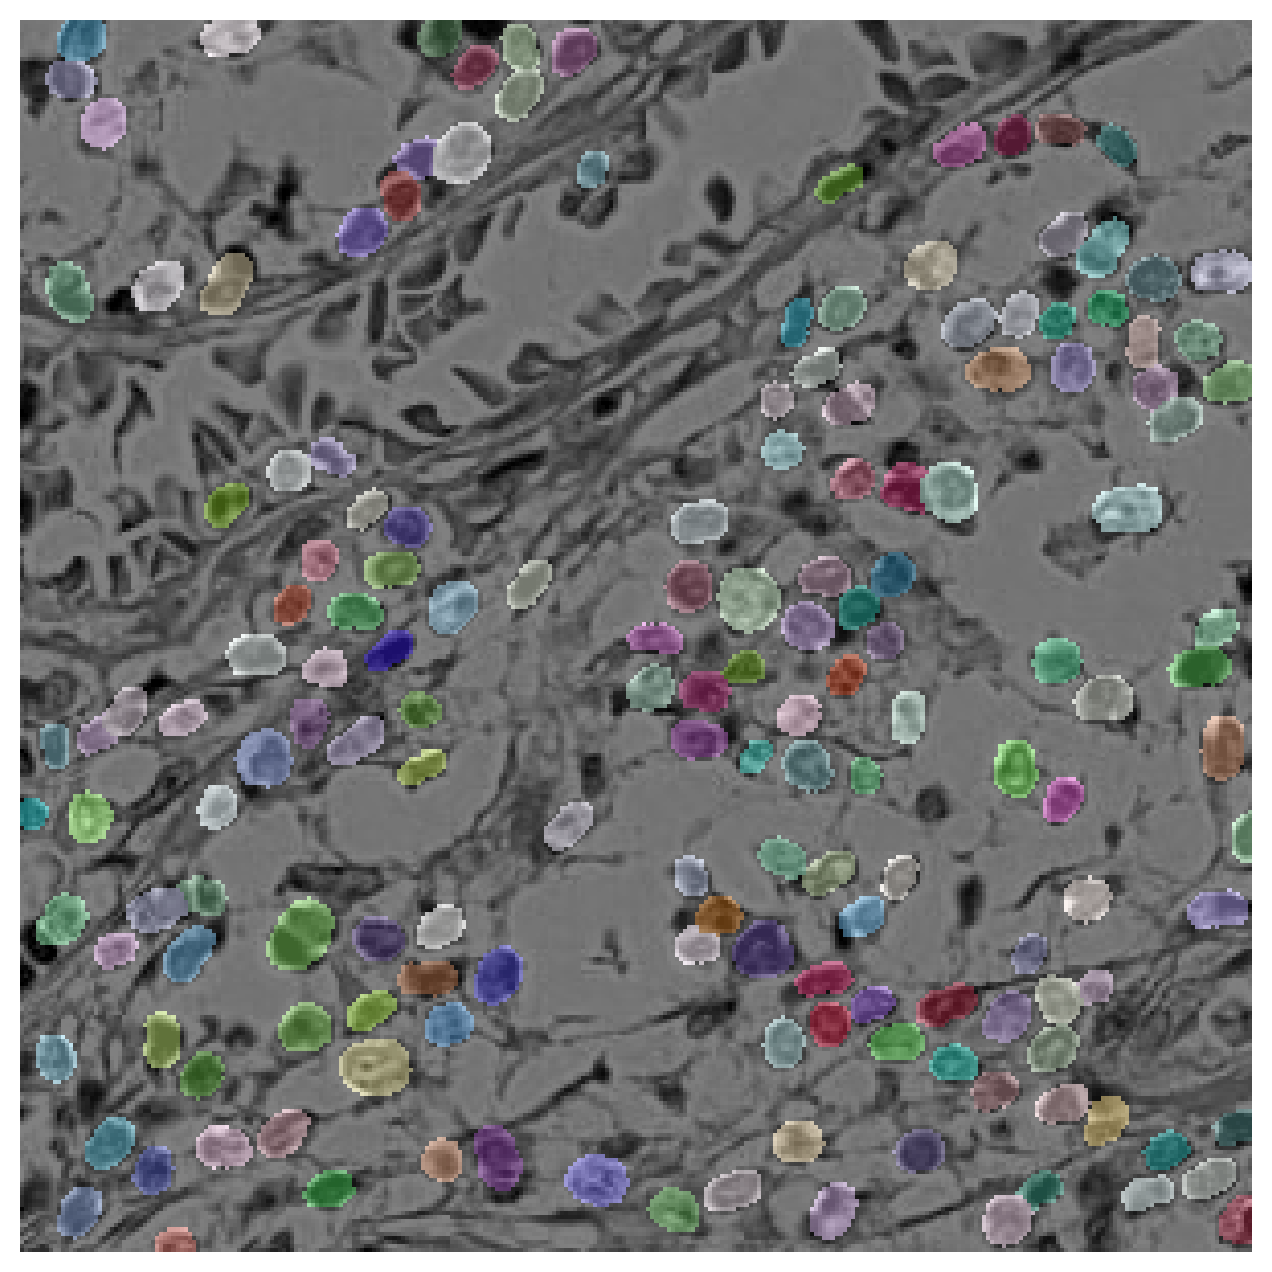

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

In [ ]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

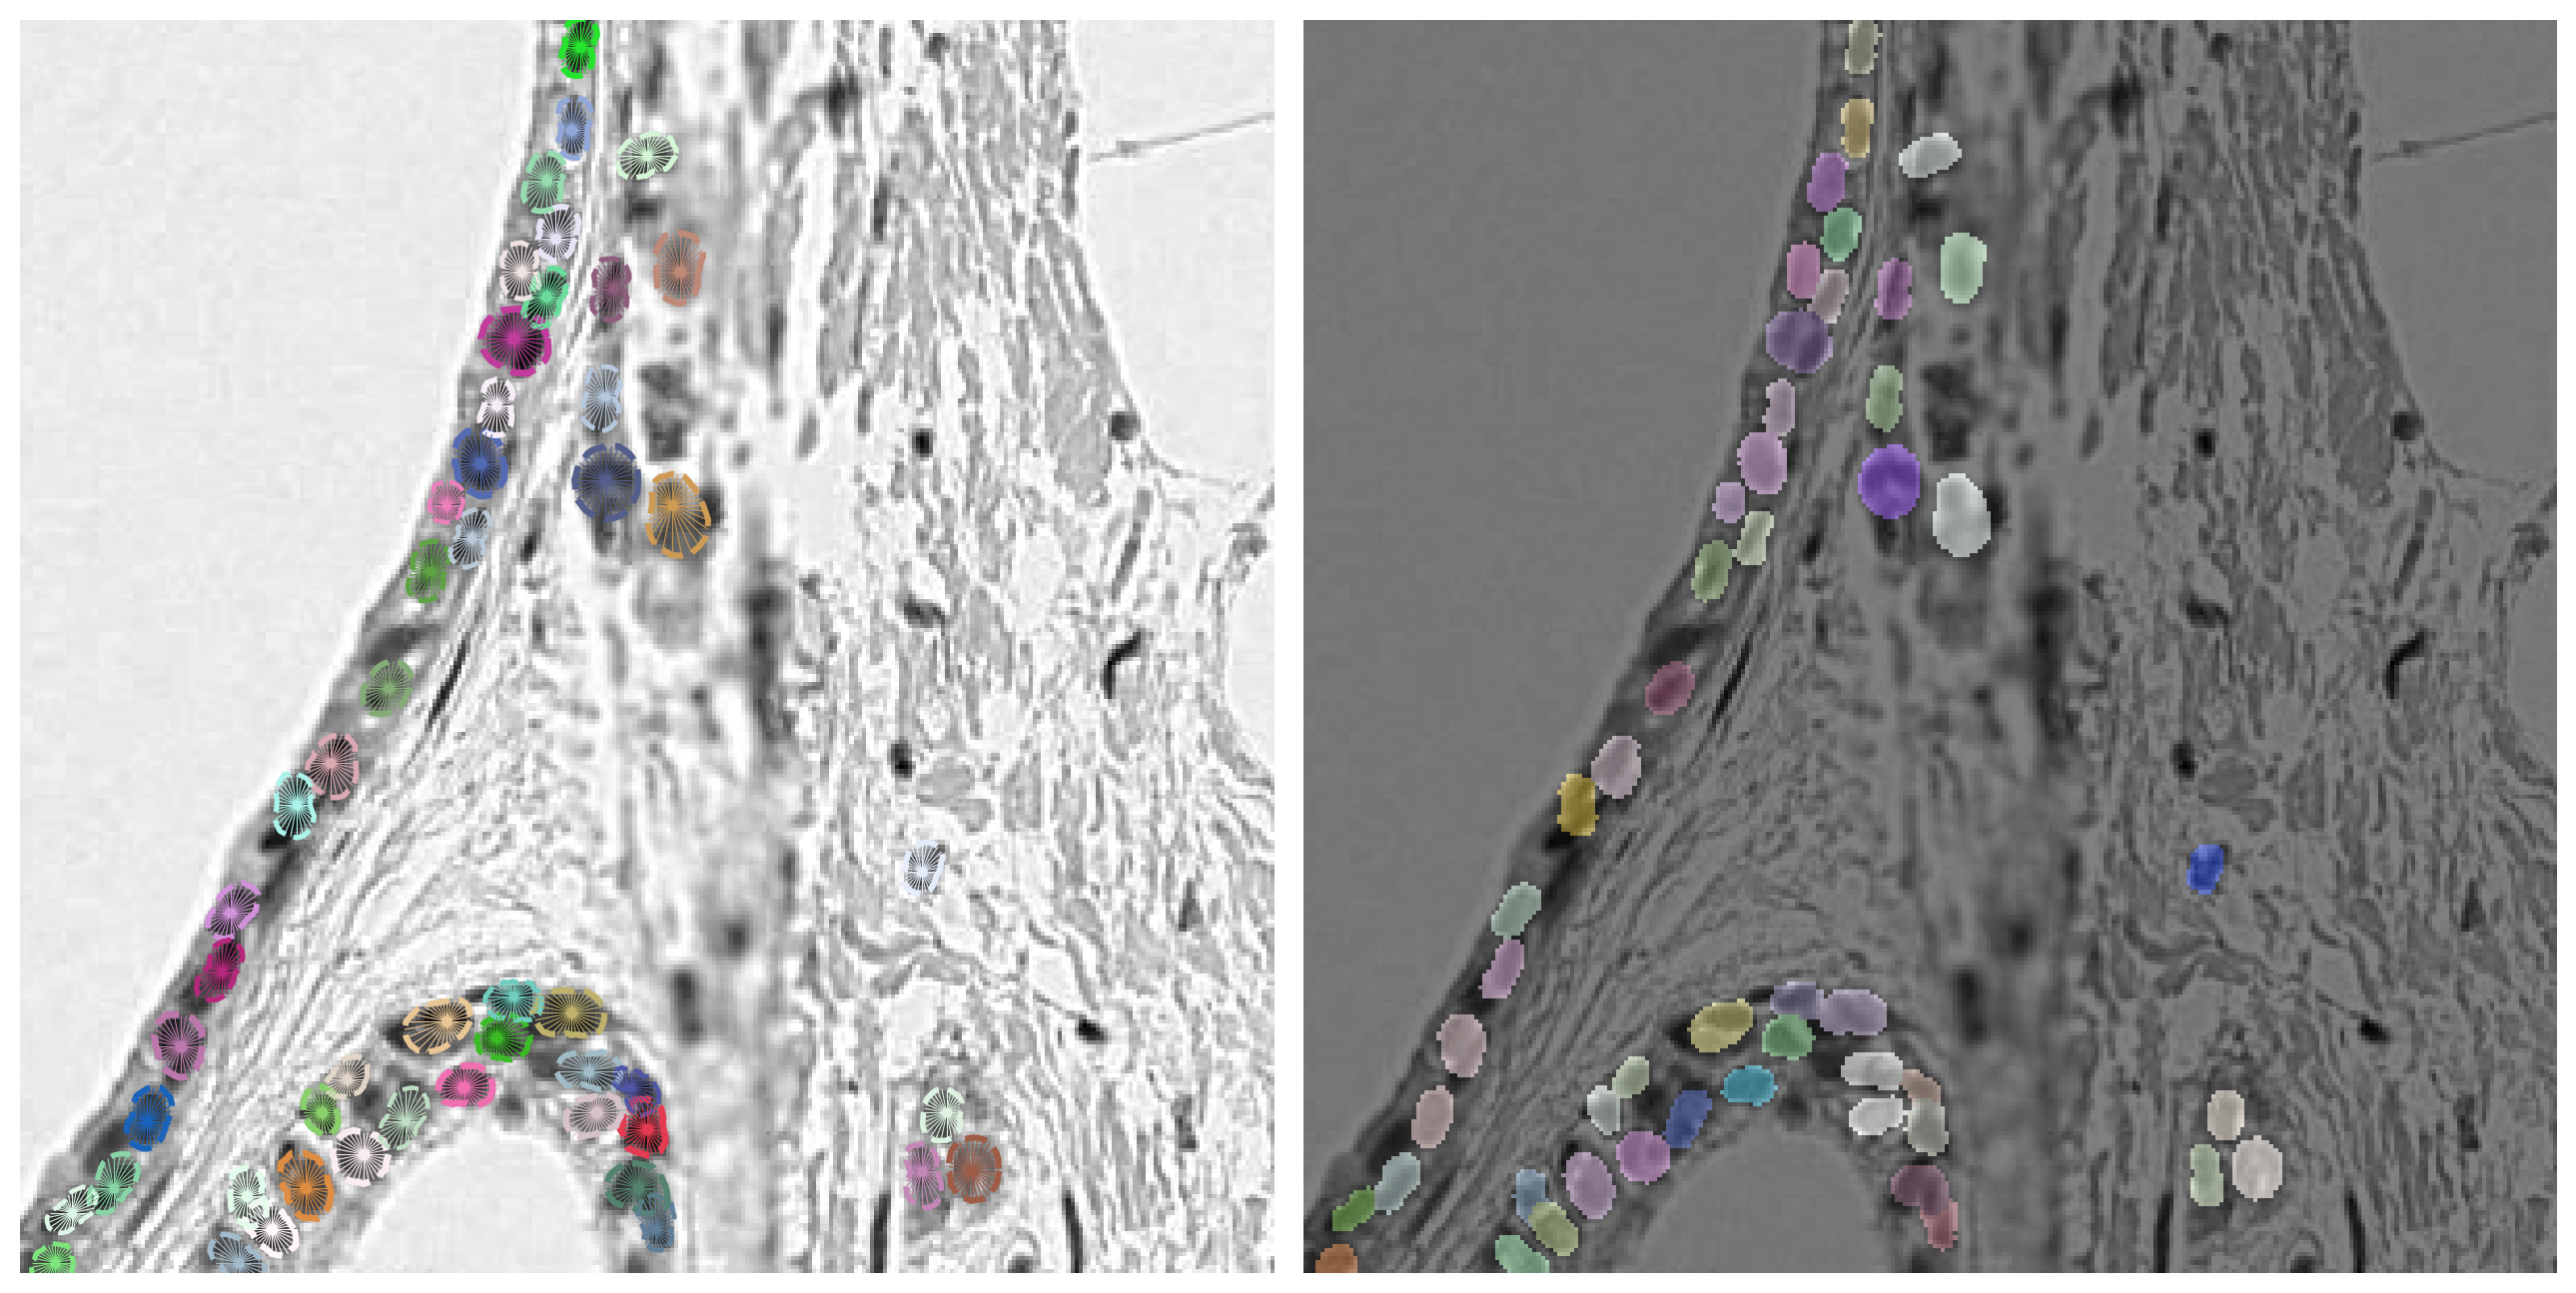

In [ ]:
example(model, 5)